In [1]:
import os
import numpy as np
from collections import defaultdict
import gzip
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score

import sys

sys.path.append("../2_train_models")
from data_loading import extract_observed_profiles
from file_configs import MergedFilesConfig

sys.path.append("../5_modisco")
from modiscolite_utils import load_modisco_results

from plot_utils import get_continuous_cmap
from motif_hits_utils import load_motif_hits
from other_motif_utils import trim_two_motifs_by_thresh, plot_motif_on_ax, compute_per_position_ic
from load_annotations_utils import load_coords_with_summits, find_peak_overlap_labels, get_ccre_bed

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# specify what set of models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

# motif names below are specific to the K562 profile modisco run
motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

# the patterns in the modisco results that correspond to the motif names above
patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

In [3]:
# Load the config object for when model outputs were merged across all folds

config = MergedFilesConfig(cell_type, model_type, data_type)

# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = config.proj_dir

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

In [4]:
# will plot the PWMs/CWMs from the [profile task] modisco patterns directly

modisco_results = load_modisco_results(config.modisco_profile_results_path)

# will plot true and predicted profiles at motifs

true_profs = extract_observed_profiles(config.plus_bw_path,
                                       config.minus_bw_path,
                                       config.all_peak_path,
                                       out_window=out_window)

pred_profs = np.exp(np.load(config.pred_profiles_all_path))

# need peak coordinates to find the profiles at motif hits

coords = load_coords_with_summits(config.all_peak_path, in_window=in_window)

# for the linear models analysis later

pred_logcounts = np.load(config.pred_logcounts_all_path).squeeze()

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [5]:
len(coords), true_profs.shape, pred_profs.shape, pred_logcounts.shape

(30534, (30534, 2, 1000), (30534, 2, 1000), (30534,))

In [6]:
# load motif hits



motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, data_type, in_window)

## Main Large Plot (Fig 2A)

In [9]:
def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False,
                     color = None, tick_len=3, tick_fontsize=6):
    assert len(profiles.shape) == 3

    # First, normalize the profiles along the output profile dimension
    # (this keeps observed profiles with 10K+ reads from dominating)
    
    # credit: I think this function is from Alex Tseng's modisco report notebook
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        # If 0, keep 0 as the quotient instead of dividing by 0
        arr_sum[arr_sum == 0] = 1  
        return arr / arr_sum
    
    profs_norm = normalize(profiles, axis=-1)

    # Compute the mean profiles across all examples
    profs_mean = np.mean(profs_norm, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color=color, linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color=color, alpha = 0.6, linewidth=0.5)

    # aesthetics below
    
    # set axes
    max_mean_val = np.max(profs_mean)
    if tick_len < 3:
        mean_ylim = max_mean_val * 1.02  # Make 5% higher
    else:
        mean_ylim = max_mean_val
        
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        for side in ["left", "top", "right", "bottom"]:
            ax.spines[side].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=tick_fontsize)
        ax.tick_params("x", length=tick_len)
        
        for side in ["left", "top", "right"]:
            ax.spines[side].set_visible(False)
            
        if tick_len < 3:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 6, mean_ylim / 7,
                                     clip_on=False, zorder=50, color="white")
        else:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 4, mean_ylim / 5,
                                     clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim))
        ax.spines["bottom"].set_color("#333333")
        

def extract_profs_at_motifs(motif_hits, coords, true_profs, pred_profs,
                             in_window, out_window, prof_width=200):
        
    def convert_motif_coords_to_prof_coords(coords, coord_indexes, motif_starts, motif_ends):
        # given genomic coordinates for motif hits,
        # convert to the position within a profile array,
        # assuming profile arrays are width (out_window)
        # and centered on peak centers
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - out_window) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
        return np.array(real_starts), np.array(real_ends)
        
    # the chromosome, start coordinate, and end coordinate of each motif hit (bed-format)
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    # boolean for whether the motif hit is in a flipped orientation
    motif_rcs = motif_hits["strand"] == "-"
    
    # convert genomic motif coordinates to indexes to slice profiles by
    motif_starts, motif_ends = convert_motif_coords_to_prof_coords(coords, coord_indexes,
                                                                   motif_starts, motif_ends)
    
    # Get exact slice indexes, centering on each motif hit
    motif_centers = (motif_starts + motif_ends) // 2
    motif_prof_starts = motif_centers - prof_width
    motif_prof_ends = motif_centers + prof_width
    
    # For each seqlet, fetch the true/predicted profiles
    true_motif_profs = []
    pred_motif_profs = []
    for coord_index, prof_start, prof_end, rc in zip(coord_indexes, motif_prof_starts, motif_prof_ends, motif_rcs):
        if not (prof_start < 0 or prof_end > out_window):
            true_prof = true_profs[coord_index, :, prof_start:prof_end]
            pred_prof = pred_profs[coord_index, :, prof_start:prof_end]
            
            # if motif is in flipped orientation, flip the profiles
            # (along both the genomic axis and the strand)
            if rc:
                true_prof = true_prof[::-1, ::-1]
                pred_prof = pred_prof[::-1, ::-1]
        
            true_motif_profs.append(true_prof)
            pred_motif_profs.append(pred_prof)

    true_motif_profs = np.stack(true_motif_profs)
    pred_motif_profs = np.stack(pred_motif_profs)
    
    return true_motif_profs, pred_motif_profs


def plot_circle_with_given_radius(ax, radius, radius_mult=0.48):
    # plot a circle on the given axis with particular radius,
    # and color that circle according to the radius magnitude
    
    cmap = get_continuous_cmap(["#D0F2F8", "#94D3E7", "#275A95", "#212158"])
    cmap_color = cmap(radius)
    
    # center the circle in the axis
    # (based on your plot size, adjust radius_mult so circle size looks good)
    
    ax.add_patch(plt.Circle((0.5, 0.5), radius * radius_mult,
                            facecolor = cmap_color, edgecolor="#0C0D40"))
    
    # delete axis lines and ticks everywhere
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(xlim=[0, 1], ylim=[0, 1], aspect=1)
    
    
def pick_middle_number(nums):
    nums = sorted(list(set(nums)))
    return nums[len(nums) // 2]

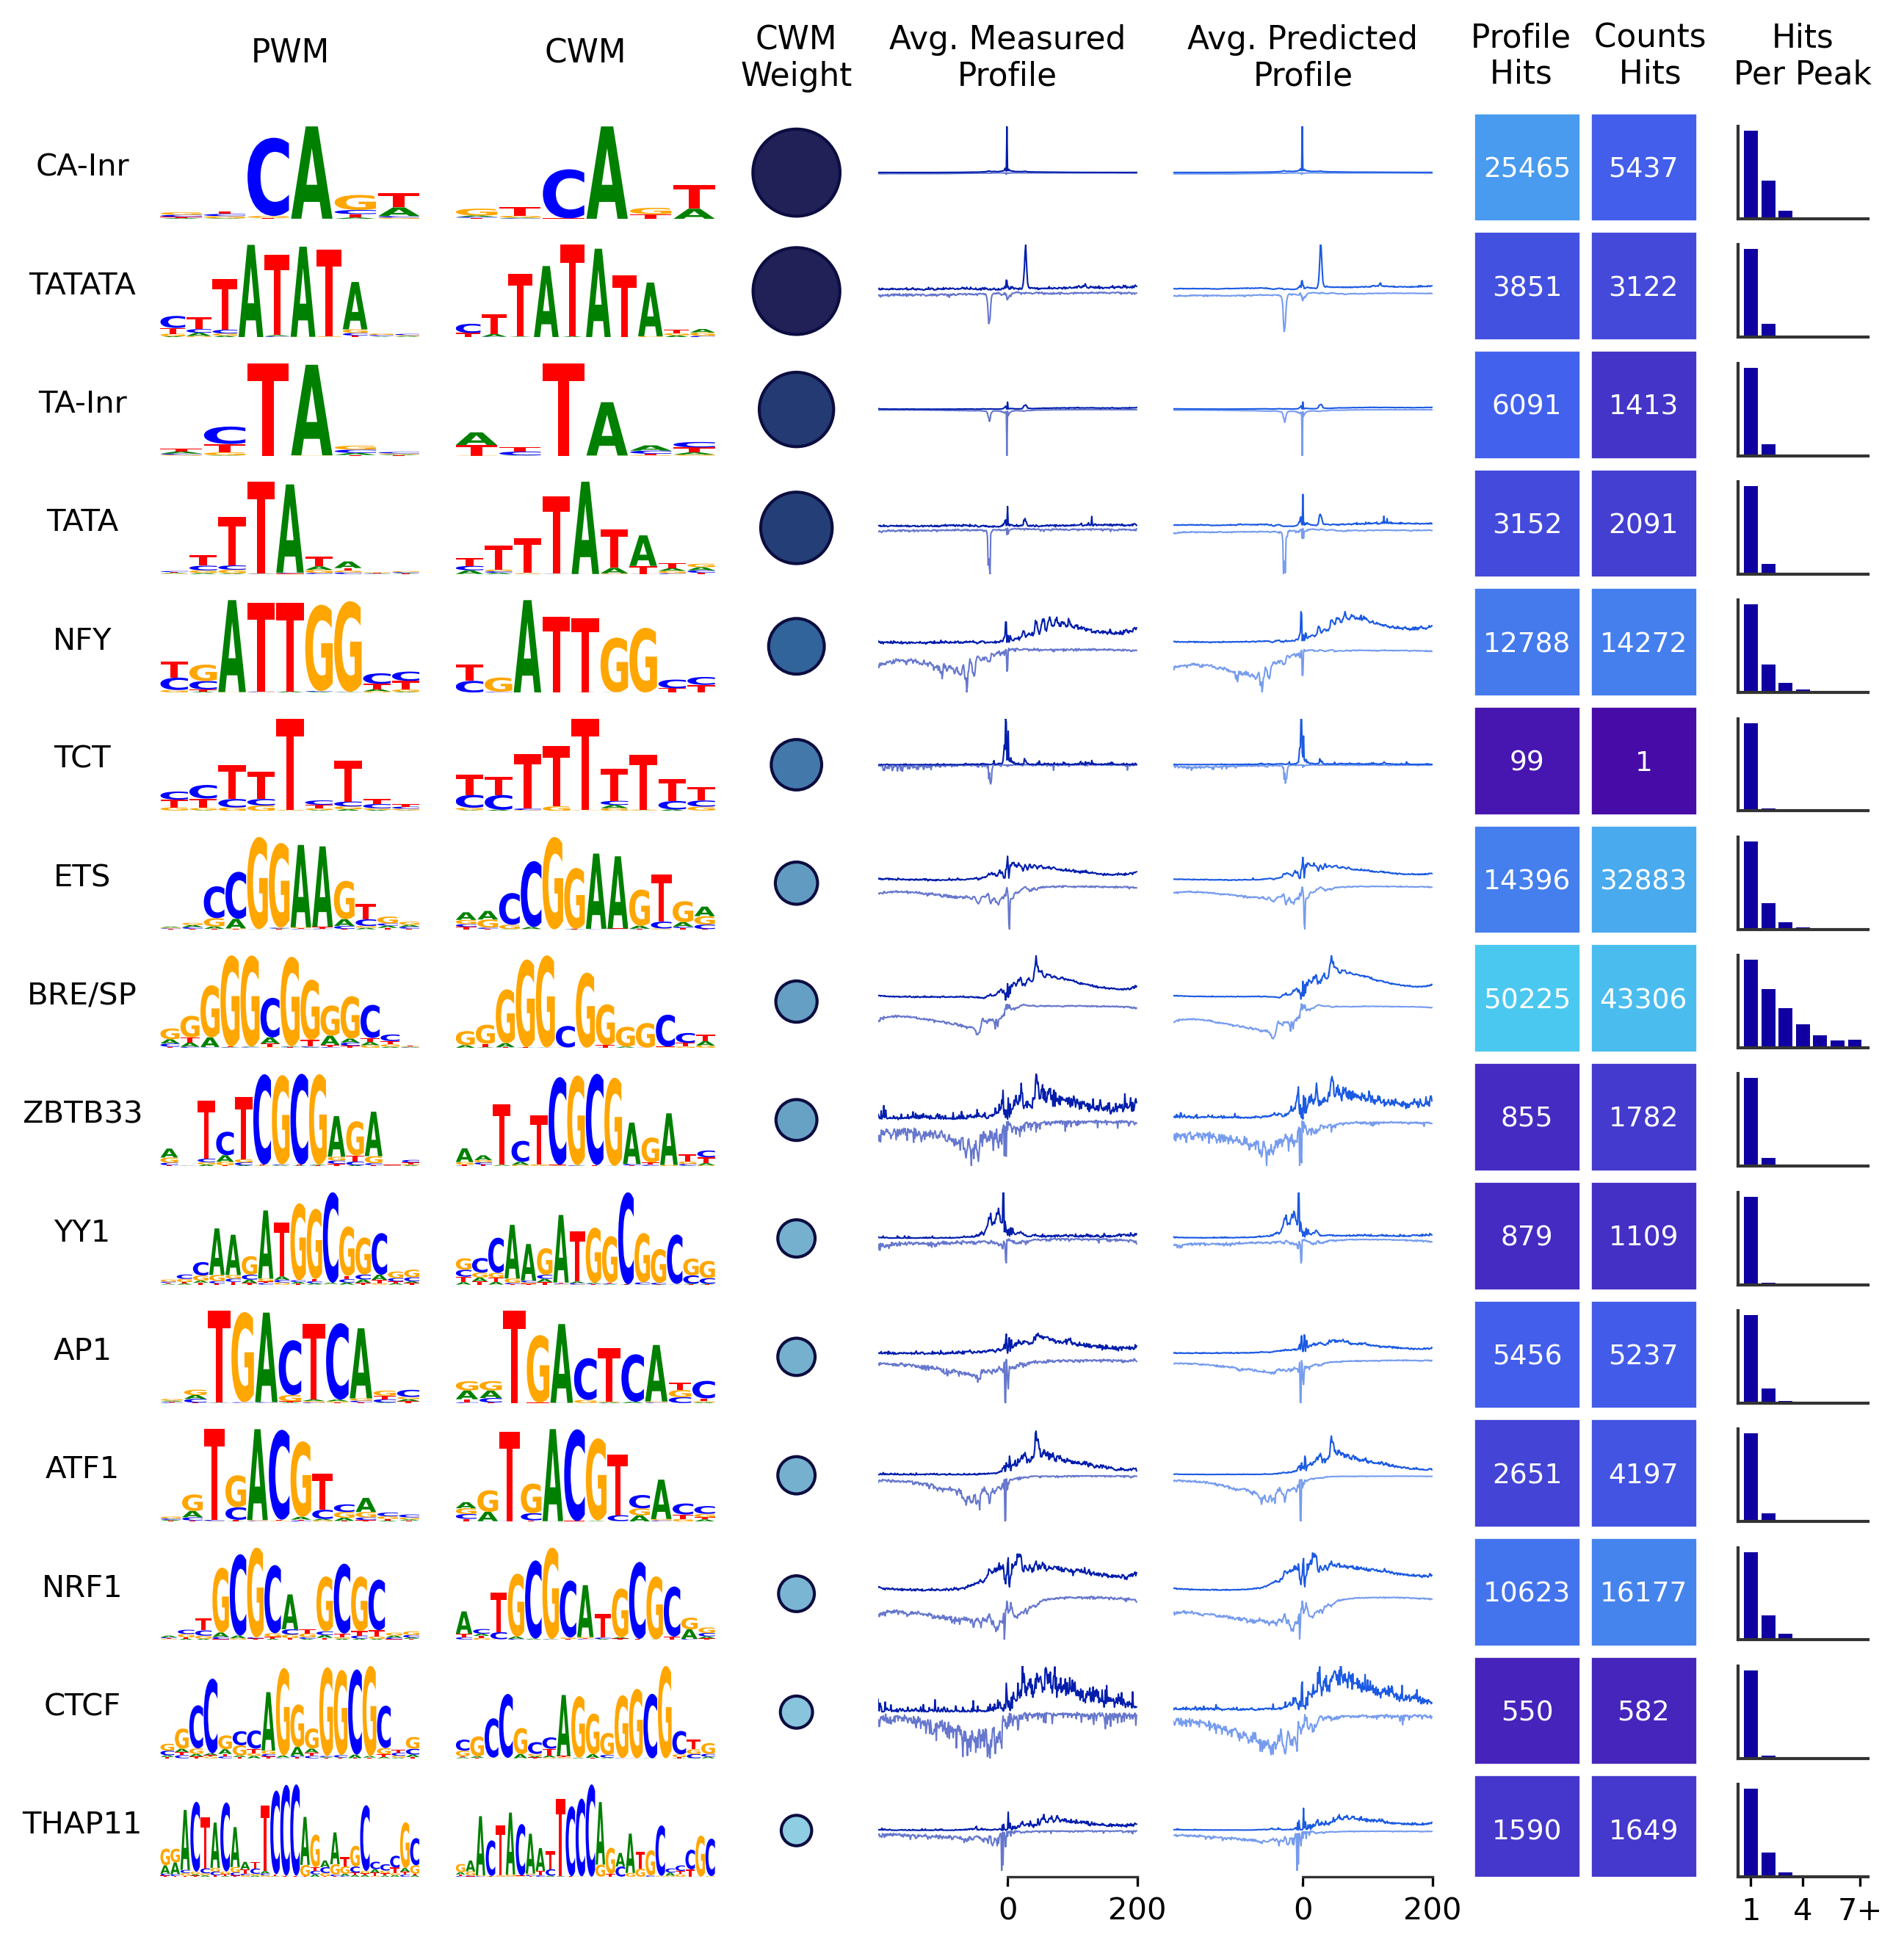

In [19]:
def plot_modisco_hits(modisco_results, patterns_to_keep,
                      motif_hits, motif_hit_counts,
                      coords, true_profs, pred_profs, 
                      in_window, out_window,
                      motif_names_list = motif_names,
                      prof_width=200, save_path=None):
    
    ### first, load up all the data used in the plot
    
    pwms_list = []
    cwms_list = []
    cwm_weights = []
    true_profs_list = []
    pred_profs_list = []
    hist_ys = []
    hist_xs = []
    motif_hit_counts = defaultdict(lambda : [])
    
    patterns = modisco_results["pos_patterns"]
    
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]

        # load PWM
        ppm = pattern["sequence"][:]
        pwm = ppm * compute_per_position_ic(ppm)[:, None]
        pwms_list.append(pwm)
        
        # Load CWM
        cwm = pattern["contrib_scores"][:]
        cwms_list.append(cwm)
        
        # Calculate CWM "weight" (like y-axis height)
        cwm_weight = np.max(cwm.sum(axis=-1))
        cwm_weights.append(cwm_weight)

        
        # Load all hits of this motif
        
        # use ax_row_i here because the motif hit caller only saw the filtered subset of motifs
        motif_hits_subset = motif_hits["profile"][motif_hits["profile"]["motif_index"] == ax_row_i]
       
        # remove duplicate motif hits, double-called because peaks were too close together
        df_tmp = motif_hits_subset.groupby(["chrom", "start", "end", "motif", "strand", "motif_index"])
        motif_hits_subset = df_tmp.agg({'peak_index': pick_middle_number}).reset_index()
        
        
        # Load the true + predicted profiles at motifs
        
        true_motif_profs, pred_motif_profs = extract_profs_at_motifs(motif_hits_subset, coords,
                                                                     true_profs, pred_profs,
                                                                     in_window, out_window,
                                                                     prof_width=200)
        true_profs_list.append(true_motif_profs)
        pred_profs_list.append(pred_motif_profs)

        
        # Count numbers of motif hits per peak
        
        hit_counts_by_peak = np.unique(motif_hits_subset["peak_index"], return_counts=True)[1]
        hist_y, hist_x = np.histogram(hit_counts_by_peak,
                                      bins=range(1, 20))  # 20 == arbitrarily large number
        hist_ys.append(hist_y)
        hist_xs.append(hist_x)
        
        motif_hit_counts["profile"].append(hit_counts_by_peak.sum())
        
        
        # repeat duplicate hit removal for counts task
        motif_hits_subset = motif_hits["counts"][motif_hits["counts"]["motif_index"] == ax_row_i]
        df_tmp = motif_hits_subset.groupby(["chrom", "start", "end", "motif", "strand", "motif_index"])
        motif_hits_subset = df_tmp.agg({'peak_index': pick_middle_number}).reset_index()
        hit_counts_by_peak = np.unique(motif_hits_subset["peak_index"], return_counts=True)[1]
        motif_hit_counts["counts"].append(hit_counts_by_peak.sum())

        
    ### sort everything identically
    
    sort_order = np.argsort(cwm_weights)[::-1]
    
    pwms = np.array(pwms_list)[sort_order]
    cwms = np.array(cwms_list)[sort_order]
    cwm_weights = np.array(cwm_weights)[sort_order]
    true_profs_list = np.array(true_profs_list, dtype=object)[sort_order]
    pred_profs_list = np.array(pred_profs_list, dtype=object)[sort_order]
    hist_ys = np.array(hist_ys, dtype=object)[sort_order]
    hist_xs = np.array(hist_xs, dtype=object)[sort_order]
    motif_names_list = np.array(motif_names_list)[sort_order]
    
    heatmap_prof_data = np.array(motif_hit_counts["profile"])[sort_order]
    heatmap_counts_data = np.array(motif_hit_counts["counts"])[sort_order]
    heatmap_data = np.array((heatmap_prof_data, heatmap_counts_data)).T
    
    # normalize cwm weights so the max is 1
    cwm_weights = cwm_weights / np.max(cwm_weights)
    
    
    ### with data all loaded, start building plot


    fig, axes = plt.subplots(len(patterns_to_keep) + 1, 7,
                             figsize=(10, 0.7 * len(patterns_to_keep)),
                             dpi=300,
                             gridspec_kw={"width_ratios":[2,2,0.7,2,2,1.8,1],
                                          "height_ratios":[0.05] + [1] * len(patterns_to_keep),
                                          "hspace":0.3, "wspace":0.17})

    # the top row of subplots are fake (for padding), so remove/hide
    for ax in axes[0, :]:
        ax.remove()

    # modify the subplot arrangement to draw heatmap over a whole column
    axes[0,5].set_axis_off()
    gs1 = axes[0,5].get_gridspec()
    for ax in axes[1:, 5]:
        ax.remove()
    heatmap = fig.add_subplot(gs1[:, 5])

    for ax_row_i in range(len(patterns_to_keep)):
        pwm = pwms[ax_row_i]
        cwm = cwms[ax_row_i]
        cwm_weight = cwm_weights[ax_row_i]
        true_profs = true_profs_list[ax_row_i]
        pred_profs = pred_profs_list[ax_row_i]
        hist_y = hist_ys[ax_row_i]
        hist_x = hist_xs[ax_row_i]
        
        ax_row = axes[ax_row_i+1]
        
        ### plot motif PWM, CWM, CWM height
        
        pwm_trim, cwm_trim = trim_two_motifs_by_thresh(pwm, cwm)
        plot_motif_on_ax(pwm_trim, ax_row[0])
        plot_motif_on_ax(cwm_trim, ax_row[1])
        
        plot_circle_with_given_radius(ax_row[2], cwm_weight)
        
        ax_row[0].set_ylabel(motif_names_list[ax_row_i],
                             fontsize=10, labelpad=22, rotation=0, y=0.4)
        
        if ax_row_i == 0:
            ax_row[0].set_title("PWM", y=1.5, fontsize=10.5)
            ax_row[1].set_title("CWM", y=1.5, fontsize=10.5)
            ax_row[2].set_title("CWM\nWeight", y=1.26, fontsize=10.5)
            
            
        ### plot true/pred profiles

        plot_avg_profile(true_profs, ax_row[3],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1,
                         color = "#001DAC")
        if ax_row_i == 0:
            ax_row[3].set_title("Avg. Measured\nProfile\n", fontsize=10.5, pad=1.5)

        plot_avg_profile(pred_profs, ax_row[4],
                         prof_width = prof_width,
                         bottom_ticks = ax_row_i == len(patterns_to_keep)-1,
                         color = "#1B5AE3")
        if ax_row_i == 0:
            ax_row[4].set_title("Avg. Predicted\nProfile\n", fontsize=10.5, pad=1.5)

            
        ### plot motif complexity histograms
            
        stop_after = 6
        hist_y = list(hist_y[:stop_after]) + [np.sum(hist_y[stop_after:])]
        hist_x = list(hist_x[:stop_after + 1])
        ax_row[6].bar(hist_x, hist_y, color="#1000A1", alpha=1)

        ax_row[6].tick_params("both", length=3)
        ax_row[6].set_yticks([])
        if ax_row_i == len(patterns_to_keep) - 1:
            xticks = hist_x[:-1] + [hist_x[-1] + 0.3]
            xticks = xticks[::3]
            xticklabels = [str(i) for i in hist_x[:-1]]
            xticklabels = xticklabels[::3]
            xticklabels.append(str(hist_x[-1]) + "+")
            ax_row[6].set_xticks(xticks, xticklabels)
        else:
            ax_row[6].set_xticks([])

        ax_row[6].spines[["left", "bottom"]].set_linewidth(1)
        ax_row[6].spines[["left", "bottom"]].set_color("#333333")
        ax_row[6].spines[["top", "right"]].set_visible(False)
            
        if ax_row_i == 0:
            ax_row[6].set_title("Hits\nPer Peak\n", fontsize=10.5, pad=1.5)

            
    ### plot heatmaps (second-to-last column)

    cmap = get_continuous_cmap(["#480CA8", "#4361EE", "#4895EF", "#4CC9F0"])
    cmap.set_bad(color='#EEEEEE')
    heatmap.imshow(np.sqrt(np.concatenate((heatmap_data.T, heatmap_data.T)).T),
                   aspect = "auto", cmap=cmap)

    heatmap.set_xticks(np.arange(3)-.5, minor=True)
    heatmap.xaxis.set_ticks_position("top")
    heatmap.set_xticks([-0.01,1.01], ["Profile \nHits ", " Counts\n Hits"],
                       fontsize=10.5)
    heatmap.tick_params(length=0, pad=2)

    # format heatmap to look better
    heatmap.grid(which="minor", color="w", linestyle='-', linewidth=4)
    heatmap.tick_params(which="minor", bottom=False, left=False, top=False)
    heatmap.tick_params(which="major", bottom=False, left=False, top=False)
    heatmap.set_yticklabels([])
    heatmap.spines[["left", "top", "bottom"]].set_visible(False)
    heatmap.spines["right"].set_color("w")
    heatmap.set_yticks(np.arange(len(heatmap_data)+1)-.5, minor=True)
    heatmap.set_ylim(len(heatmap_data) - 0.6, -0.6)

    heatmap.set_xlim(-0.5, 1.5)

    # add text on top of heatmaps
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if not np.isnan(heatmap_data[i,j]):
                text = heatmap.text(j, i+0.02, int(heatmap_data[i,j]),
                           ha="center", va="center", color="w", fontsize=9)
            else:
                text = heatmap.text(j-0.03, i+0.02, 0,
                           ha="center", va="center", color="#333333", fontsize=9)

    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        
            
plot_modisco_hits(modisco_results,
                  patterns_to_keep, motif_hits, motif_hit_counts,
                  coords, true_profs, pred_profs,
                  in_window, out_window,
                  save_path = figures_dir + "2main_squish.png")

## Linear Models of Read Counts Using Motif Hits

In [23]:
# To stratify performance across folds, we need to label
# each test example with which fold it was in the test set for.

# Fold assignment (below) needs to match what was in
# 1_process_data/_split_peaks_train_val_test.py

FOLDS = [["chr1", "chr4"],
         ["chr2", "chr13", "chr16"],
         ["chr5", "chr6", "chr20", "chr21"],
         ["chr7", "chr8", "chr9"],
         ["chr10", "chr11", "chr12"],
         ["chr3", "chr14", "chr15", "chr17"],
         ["chr18", "chr19", "chr22", "chrX", "chrY"]]

def get_fold_label(chrom):
    # returns *0-indexed* fold num that this chromosome was in the test set for
    for fold_i, fold_chroms in enumerate(FOLDS):
            if chrom in fold_chroms:
                return fold_i
    return -1

def make_fold_labels(coords):
    # Make list of len [num_peaks] / length of all_peak_path file,
    # where entry i is the fold that example i was in the test set for.
    
    # coord[0] is the chromosome (first column from bed file)
    fold_labels = [get_fold_label(coord[0]) for coord in coords]
    
    # check we assigned a fold for every single example/peak
    assert all([label > -1 for label in fold_labels]), fold_labels
    return fold_labels
        
    
fold_labels = np.array(make_fold_labels(coords))

In [26]:
def _fit_model_get_rsquared(to_predict, predictor, fold_labels=fold_labels):
    
    if len(predictor.shape) == 1:
        predictor = predictor[:, None]
        
    assert predictor.shape[0] == len(to_predict), (predictor.shape[0], len(to_predict))
    
    to_predict = to_predict.squeeze()[:, None]
    assert to_predict.shape == (len(to_predict), 1), to_predict.shape
    
    fold_rsquareds = []
    for fold_i in range(len(FOLDS)):
        assert len(to_predict) == len(fold_labels), (len(to_predict), len(fold_labels))
        assert len(predictor) == len(fold_labels), (len(predictor), len(fold_labels))

        to_predict_train = to_predict[fold_labels != fold_i]
        to_predict_test = to_predict[fold_labels == fold_i]
        predictor_train = predictor[fold_labels != fold_i]
        predictor_test = predictor[fold_labels == fold_i]

        model = sm.OLS(to_predict_train, sm.add_constant(predictor_train))
        fit_model = model.fit()
        
        test_preds = fit_model.predict(sm.add_constant(predictor_test))
        
        rsquared_raw = r2_score(to_predict_test, test_preds)
        adj_factor = (len(predictor_test) - 1) / (len(predictor_test) - predictor_test.shape[-1] - 1)
        rsquared_adj = 1 - (1 - rsquared_raw) * adj_factor
    
        fold_rsquareds.append(rsquared_adj)

    return np.mean(fold_rsquareds)

In [11]:
true_logcounts = np.log1p(true_profs.sum(axis=(-1,-2)))

In [29]:
# ProCapNet performance: read counts ~ predicted read counts (to get baseline R^2)

_fit_model_get_rsquared(true_logcounts, pred_logcounts)

0.5652925460073127

In [30]:
# read counts ~ # of motifs counted per peak (motif identity not separated)

_fit_model_get_rsquared(true_logcounts, motif_hit_counts["profile"].sum(axis=-1))

0.1247250708461533

In [31]:
# read counts ~ # of motifs counted per peak (motif identity separated)
# motif identity matters a lot (of course)

_fit_model_get_rsquared(true_logcounts, motif_hit_counts["profile"])

0.2537818337493293

In [33]:
# read counts ~ # of *unique* motifs counted per peak (motif identity separated)
# motif identity matters pt 2 - motif diversity is huge fraction of R^2

_fit_model_get_rsquared(true_logcounts, 1 * (motif_hit_counts["profile"] > 0))

0.23039123471352305

In [34]:
# read counts ~ # of *unique* motifs counted per peak (motif identity not separated)

_fit_model_get_rsquared(true_logcounts, (motif_hit_counts["profile"] > 0).sum(axis=-1))

0.05870170817159762

## Stats On Numbers Of Motifs

In [12]:
print("Avg. number of motifs per peak:")
print(np.mean(motif_hit_counts["profile"].sum(axis=-1)))
print("Median number of motifs per peak:")
print(np.median(motif_hit_counts["profile"].sum(axis=-1)))

print("Avg. number of unique motifs per peak:")
print(np.mean((motif_hit_counts["profile"] > 0).sum(axis=-1)))
print("Median number of unique motifs per peak:")
print(np.median((motif_hit_counts["profile"] > 0).sum(axis=-1)))

Avg. number of motifs per peak:
5.8375581319185175
Median number of motifs per peak:
6.0
Avg. number of unique motifs per peak:
3.4555904892906266
Median number of unique motifs per peak:
3.0


Num peaks with no motifs found:
101
Fraction of peaks with no motifs found:
0.003307788039562455
Num peaks with <2 motifs found:
648
Fraction of peaks with <2 motifs found:
0.021222244055806642


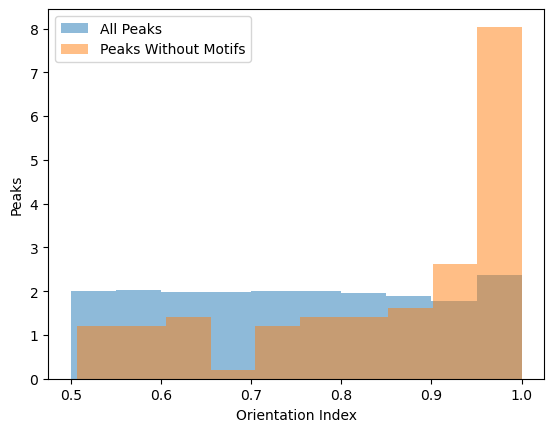

Fraction of no-motif peaks with OI = 1:
0.27722772277227725


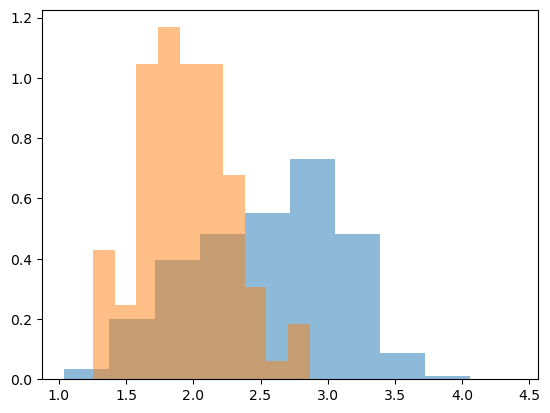

In [14]:
# Peaks with no motifs

print("Num peaks with no motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) == 0))
print("Fraction of peaks with no motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) == 0) / motif_hit_counts["profile"].shape[0])

print("Num peaks with <2 motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) < 2))
print("Fraction of peaks with <2 motifs found:")
print(np.sum(motif_hit_counts["profile"].sum(axis=-1) < 2) / motif_hit_counts["profile"].shape[0])


def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)
peaks_no_motifs_ois = ois[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(ois, density=True, alpha=0.5, label="All Peaks")
plt.hist(peaks_no_motifs_ois, density=True, alpha=0.5, label="Peaks Without Motifs")
plt.legend()
plt.xlabel("Orientation Index")
plt.ylabel("Peaks")
plt.show()

print("Fraction of no-motif peaks with OI = 1:")
print(np.sum(peaks_no_motifs_ois == 1) / peaks_no_motifs_ois.shape[0])

true_logcounts = np.log10(true_profs.sum(axis=(-1,-2)) + 1)
peaks_no_motifs_logcounts = true_logcounts[motif_hit_counts["profile"].sum(axis=-1) == 0]

plt.hist(true_logcounts, density=True, alpha=0.5)
plt.hist(peaks_no_motifs_logcounts, density=True, alpha=0.5)
plt.show()

In [35]:
ccre_bed = get_ccre_bed(cell_type, proj_dir)

ccre_annots = find_peak_overlap_labels(coords, ccre_bed, in_window, out_window)

In [36]:
num_promoters_no_motifs = np.sum(motif_hit_counts["profile"][ccre_annots["PLS"]].sum(axis=-1) == 0)
num_promoters = np.sum(ccre_annots["PLS"])

print("Num promoters with no motifs, num promoters:")
print(num_promoters_no_motifs, num_promoters)
print("Fraction of promoters with no motifs found:")
print(num_promoters_no_motifs / num_promoters)

Num promoters with no motifs, num promoters:
7 16960
Fraction of promoters with no motifs found:
0.0004127358490566038


In [38]:
num_enhancers_no_motifs = np.sum(motif_hit_counts["profile"][ccre_annots["dELS"]].sum(axis=-1) == 0)
num_enhancers = np.sum(ccre_annots["dELS"])

print("Num enhancers with no motifs, num enhancers:")
print(num_enhancers_no_motifs, num_enhancers)
print("Fraction of enhancers with no motifs found:")
print(num_enhancers_no_motifs / num_enhancers)

Num enhancers with no motifs, num enhancers:
25 5648
Fraction of enhancers with no motifs found:
0.004426345609065156


## Motif Distributions Around Summits Plots

In [25]:
def convert_motif_start_to_prof_pos(peak_coords, motif_start, motif_end):
    peak_start, peak_end = peak_coords[1:3]
    real_start = motif_start - peak_start - (in_window - out_window) // 2
    return real_start, real_start + (motif_end - motif_start)


def plot_motif_pos_dist(motif_i, motif_hits_peaks, coords, 
                        uni_or_bi = "uni", draw_summit = False, all_peaks = False,
                        save_dir = None):
    
    assert uni_or_bi in ["uni", "bi"], uni_or_bi
    assert draw_summit in [False, True], draw_summit
    
    motif_hit_positions_across_peaks = defaultdict(lambda : [])
    
    peak_widths = []
    summit_bi_pairs = []
    # for every peak...
    for peak_index, motif_hits_in_peak in enumerate(motif_hits_peaks["profile"]):
        # get the locations of this motif's instances within this peak window
        hits_of_this_motif = motif_hits_in_peak[motif_hits_in_peak["motif_index"] == motif_i]

        # if no hits of this motif in this peak, and we don't plan to plot every peak, skip
        if hits_of_this_motif.shape[0] == 0 and not all_peaks:
            continue
        
        peak_coords = coords[peak_index]
        peak_start = peak_coords[1]
        summit_pos, summit_neg = peak_coords[-2:]
        
        peak_is_unidirectional = (summit_pos is None) or (summit_neg is None)
        
        # if there is only one summit (because there's only one strand)...
        if peak_is_unidirectional:
            if summit_pos is None:  # peak on - strand
                summit = summit_neg
            else:
                summit = summit_pos
        else:
            # ignore peaks that don't match canonical bidirectional peak orientation,
            # where the negative strand summit is after the positive strand summit
            # (messes up plot)
            if summit_pos < summit_neg:
                continue  
                
            # center on the pos strand by default 
            summit = summit_pos
            
        # will use this to calculate how off from the center cordinate each motif is
        summit_offset = summit - peak_start - in_window // 2
        
        # if there is at least one hit of this motif in this peak...
        if hits_of_this_motif.shape[0] > 0:
            # make an array to annotate motif instance positions in
            motif_hit_positions = np.zeros((out_window,))

            # for motif instance in peak...
            for _, hit in hits_of_this_motif.iterrows():
                # adjust coordinates to be relative to summit / center of plot
                hit_start, hit_end = convert_motif_start_to_prof_pos(peak_coords,
                                                                     hit["start"],
                                                                     hit["end"])
                
                hit_start = hit_start - summit_offset
                hit_end = hit_end - summit_offset
                
                # annotate motif position in this array
                # (sign here is to save if motif is in + or - orientation; will plot differently)
                if hit["strand"] == "+":
                    motif_hit_positions[hit_start:hit_end] = 1
                else:
                    motif_hit_positions[hit_start:hit_end] = -1
                        

            if peak_is_unidirectional:
                # if the peak is unidirectional and on the reverse strand,
                # reverse the motif position annotation array
                # (so that motifs that position consistently w.r.t. TSSs will line up,
                # regardless of what strand the TSS is on)
                if summit_pos is None:  # peak on - strand
                    motif_hit_positions = motif_hit_positions[::-1] * -1
                    
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
            
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                
                # for bidirectional peaks, we also need to just save summit positions in order to plot them
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
                
        elif all_peaks:
            # if we want to plot all peaks, including those without this motif,
            # then just add an empty vector whenever there's a motif-less peak (for this motif)
            motif_hit_positions = np.zeros((out_window,))
            
            if peak_is_unidirectional:
                motif_hit_positions_across_peaks["uni"].append(motif_hit_positions)
            else:
                motif_hit_positions_across_peaks["bi"].append(motif_hit_positions)
                summit_bi_pairs.append([summit_pos - summit, summit_neg - summit])
                peak_widths.append(np.abs(summit_pos - summit_neg))
    
    motif_hit_positions_across_peaks["uni"] = np.array(motif_hit_positions_across_peaks["uni"])
    motif_hit_positions_across_peaks["bi"] = np.array(motif_hit_positions_across_peaks["bi"])
    summit_bi_pairs = np.array(summit_bi_pairs)
    peak_widths = np.array(peak_widths)
    
    motif_hit_positions_across_peaks["bi"] = motif_hit_positions_across_peaks["bi"][peak_widths.argsort()]
    summit_bi_pairs = summit_bi_pairs[peak_widths.argsort()]
    
    # for any individual plot, we only want to plot either the unidirectional or bidirectional peaks
    # (yes I know calculating both above is inefficient)
    hit_positions = motif_hit_positions_across_peaks[uni_or_bi]
    
    # if we want to add a gray line for every summit position in every peak,
    # we need to modify the array of hit positions to also include that info
    if draw_summit:
        if uni_or_bi == "bi":
            for i in range(len(hit_positions)):
                for pos in summit_bi_pairs[i]:
                    summit_spot = pos + hit_positions.shape[-1] // 2
                    if hit_positions[i, summit_spot] == 0:
                        hit_positions[i, summit_spot] = np.nan
        else:
            # assuming this is the centering of the summits from above for uni peaks
            for i in range(len(hit_positions)):
                hit_positions[i, out_window//2] = np.nan

                
    # time to actually plot
                
    plt.figure(figsize=(2.5, 1.3), dpi=300)
                
    # set colormap so the two motif orientations are opposite colors, and summits are gray
    cmap = matplotlib.cm.get_cmap("seismic").copy()
    cmap.set_bad(color='#999999')
    plt.imshow(hit_positions, aspect="auto", cmap=cmap)

    plt.title(motif_names[motif_i], fontsize=13)

    xticks = np.arange(0, out_window + 1, 100)
    plt.xticks(xticks, np.abs(xticks - out_window // 2), fontsize=10)

    if uni_or_bi == "bi":
        plt.xlim(150, out_window - 400)
    else:
        plt.xlim(150, out_window - 400)

    plt.gca().tick_params(length=2, pad=2)


    if uni_or_bi == "bi":
        plt.ylabel("Bi. Peaks", fontsize=12)
        if all_peaks:
            plt.xlabel("Distance To Pos. Summit,\nAll Peaks", fontsize=12)
        else:
            plt.xlabel("Distance To Pos. Summit,\nPeaks With Motif", fontsize=12)
    else:
        plt.ylabel("Uni. Peaks", fontsize=12)
        if all_peaks:
            plt.xlabel("Distance To Summit,\nAll Peaks", fontsize=12)
        else:
            plt.xlabel("Distance To Summit,\nPeaks With Motif", fontsize=12)

    plt.yticks([])

    if save_dir is not None:
        fname = "_".join(["2_motif_pos_dist", motif_names[motif_i].replace("/","-"), uni_or_bi])
        plt.savefig(save_dir + fname + ".png",
                    bbox_inches = 'tight', pad_inches = 0, dpi = 300)

    plt.show()

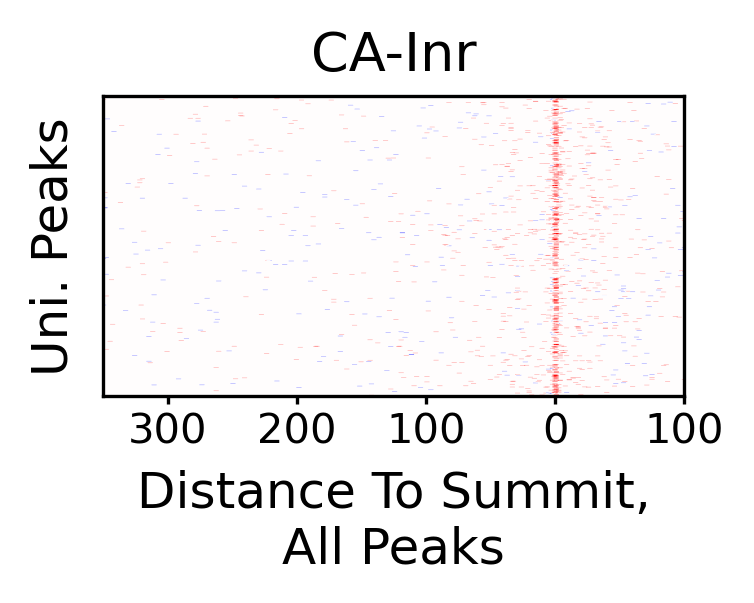

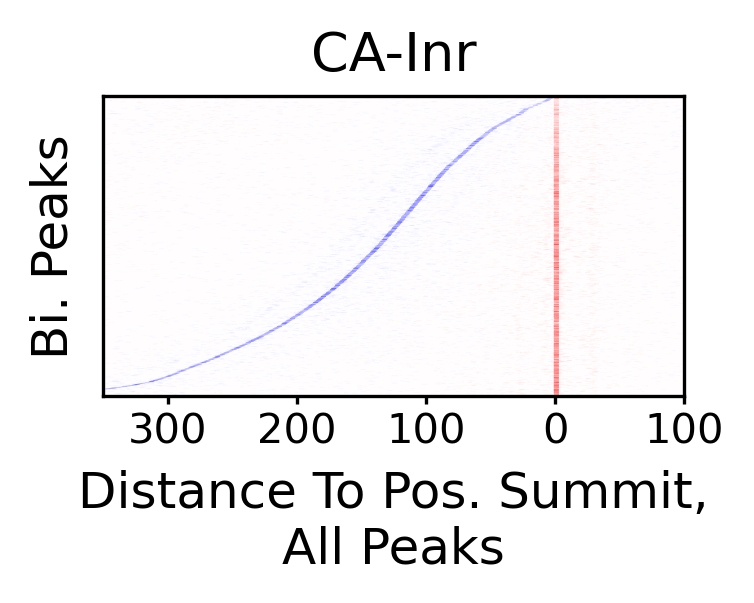

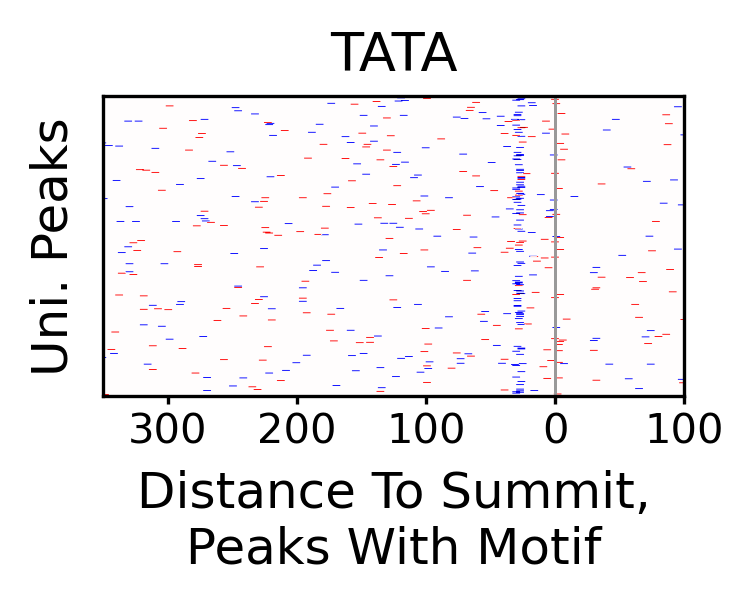

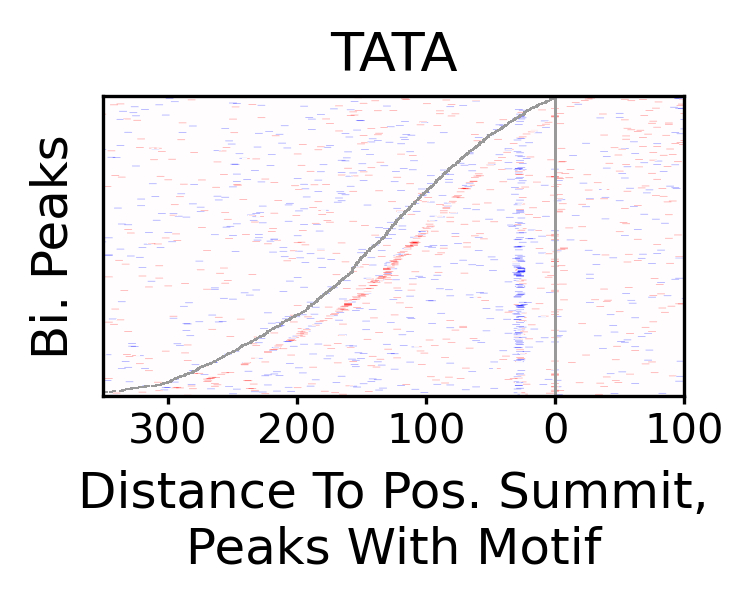

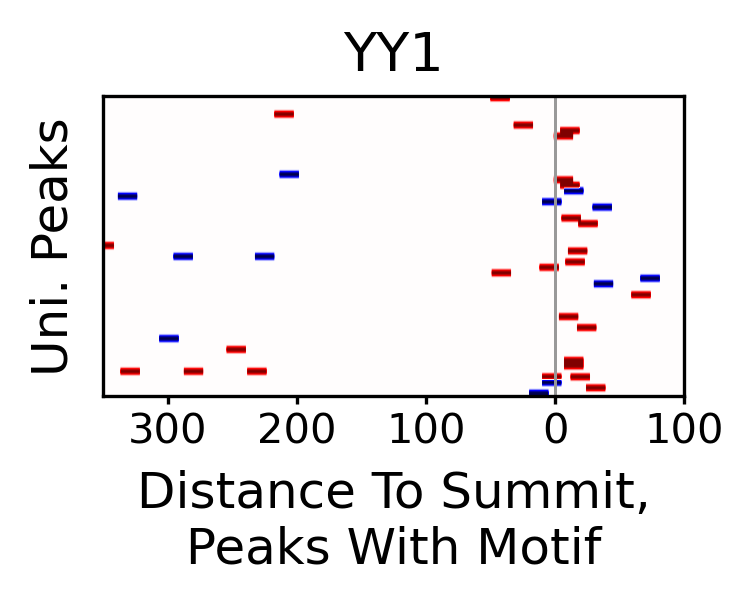

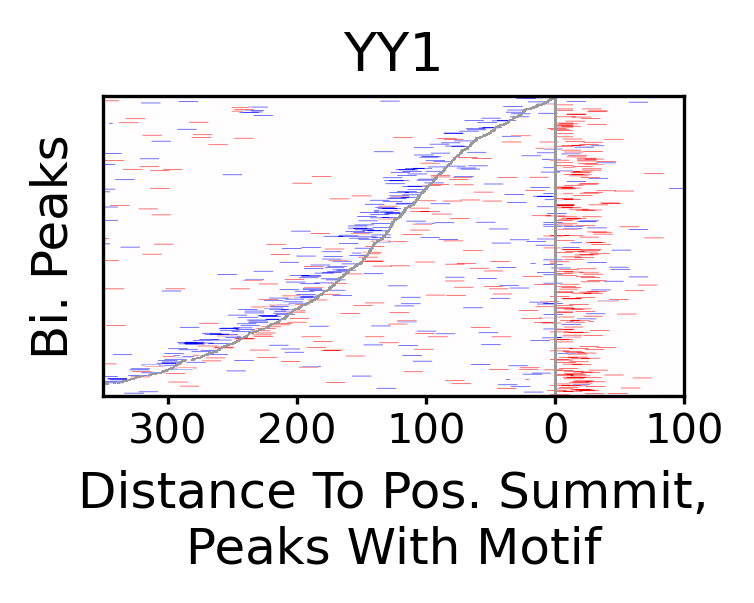

In [27]:
for i in range(len(motif_names)):
    if motif_names[i] not in ["TATA", "CA-Inr", "YY1"]:
        continue
        
    plot_motif_pos_dist(i, motif_hits_peaks, coords, 
                        uni_or_bi = "uni",
                        draw_summit = motif_names[i] != "CA-Inr",
                        all_peaks = motif_names[i] == "CA-Inr",
                        save_dir = figures_dir)

    plot_motif_pos_dist(i, motif_hits_peaks, coords, 
                        uni_or_bi = "bi",
                        draw_summit = motif_names[i] != "CA-Inr",
                        all_peaks = motif_names[i] == "CA-Inr",
                        save_dir = figures_dir)